# DPO vs RLHF: A Tale of Two Training Methods

So you've seen both DPO (Direct Preference Optimization) and RLHF (Reinforcement Learning from Human Feedback) in action. They both accomplish the same goal — teaching a language model to follow human preferences — but they take very different paths to get there.

Think of it like this: RLHF is the scenic route with multiple stops, while DPO is the highway straight to your destination.

Let's break down what makes them different, when you'd choose one over the other, and why DPO has become the darling of the open-source world. (Spoiler: it's simpler and cheaper.)

## The Training Pipeline: Where the Paths Diverge

Here's where things get interesting.

### RLHF: The Three-Act Structure

RLHF follows a three-stage process:

```
1. Supervised Fine-Tuning (SFT) — teach the model to respond well
2. Train a Reward Model — teach a critic to score responses
3. PPO Training — let the model learn from the critic's feedback
```

It's like training a chef: first you show them how to cook (SFT), then you train a food critic to score dishes (reward model), then the chef practices making dishes while the critic provides feedback (PPO).

### DPO: Cutting Out the Middleman

DPO simplifies this to just two stages:

```
1. Supervised Fine-Tuning (SFT) — teach the model to respond well
2. DPO on preference pairs — directly optimize preferences
```

Same chef analogy, but skip the critic entirely. Instead, you just show the chef pairs of dishes and tell them "this one is better than that one" repeatedly until they get it.

The reward model stage? Gone. The complex reinforcement learning? Gone. Just you, your model, and preference data.

This isn't just conceptually simpler — it has massive practical implications.

## Memory: The Real Budget Killer

Let's talk GPU memory. Because if you've ever tried to fine-tune a large model, you know this is where the rubber meets the road.

### RLHF's Ensemble Cast

During PPO training, RLHF needs to keep **four different models** in memory:

1. **Policy Model** (trainable) — the model we're actually training
2. **Value Model** (trainable) — estimates future rewards
3. **Reward Model** (frozen) — scores the quality of responses
4. **Reference Model** (frozen) — prevents the policy from drifting too far

Four models. At the same time. In GPU memory.

If you're training a 7B parameter model, you're effectively using memory for ~28B parameters worth of models. That's... a lot.

### DPO's Minimalist Approach

DPO only needs **two models**:

1. **Policy Model** (trainable) — the model we're training
2. **Reference Model** (frozen) — prevents drift from the starting point

That's it. No reward model, no value model. Just the essentials.

**The math is simple: DPO uses roughly half the memory of RLHF.**

This isn't just theoretical — it means the difference between needing 4x A100s vs 2x A100s. Between "we can do this" and "we need more budget."

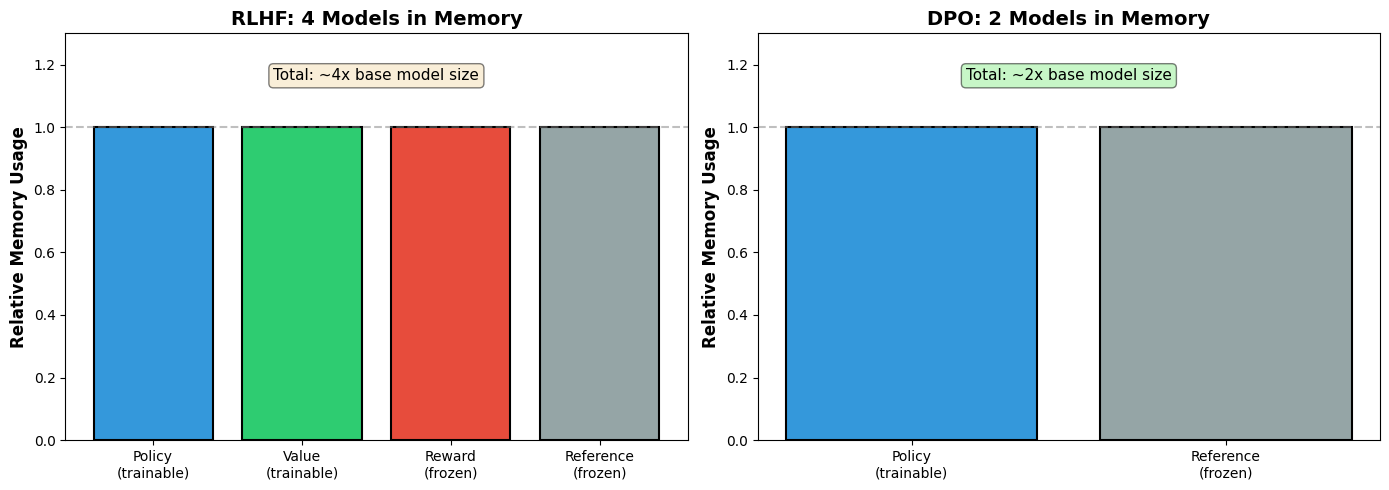


Memory Comparison Summary:
RLHF requires: 4 models simultaneously
DPO requires:  2 models simultaneously

Memory savings: ~50% with DPO

For a 7B parameter model:
  RLHF: ~28B parameters worth of memory
  DPO:  ~14B parameters worth of memory


In [1]:
# Let's visualize that memory difference
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RLHF visualization
models_rlhf = ['Policy\n(trainable)', 'Value\n(trainable)', 'Reward\n(frozen)', 'Reference\n(frozen)']
colors_rlhf = ['#3498db', '#2ecc71', '#e74c3c', '#95a5a6']
axes[0].bar(range(4), [1, 1, 1, 1], color=colors_rlhf, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(models_rlhf, fontsize=10)
axes[0].set_ylabel('Relative Memory Usage', fontsize=12, fontweight='bold')
axes[0].set_title('RLHF: 4 Models in Memory', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.3)
axes[0].axhline(y=1, color='gray', linestyle='--', alpha=0.5)
axes[0].text(1.5, 1.15, 'Total: ~4x base model size', ha='center', fontsize=11, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# DPO visualization
models_dpo = ['Policy\n(trainable)', 'Reference\n(frozen)']
colors_dpo = ['#3498db', '#95a5a6']
axes[1].bar(range(2), [1, 1], color=colors_dpo, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(2))
axes[1].set_xticklabels(models_dpo, fontsize=10)
axes[1].set_ylabel('Relative Memory Usage', fontsize=12, fontweight='bold')
axes[1].set_title('DPO: 2 Models in Memory', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.3)
axes[1].axhline(y=1, color='gray', linestyle='--', alpha=0.5)
axes[1].text(0.5, 1.15, 'Total: ~2x base model size', ha='center', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nMemory Comparison Summary:")
print("=" * 50)
print(f"RLHF requires: 4 models simultaneously")
print(f"DPO requires:  2 models simultaneously")
print(f"\nMemory savings: ~50% with DPO")
print(f"\nFor a 7B parameter model:")
print(f"  RLHF: ~28B parameters worth of memory")
print(f"  DPO:  ~14B parameters worth of memory")

## Training Stability: The Headache Factor

Here's where DPO really shines. Let me explain through the lens of what can go wrong.

### RLHF's Stability Issues

Reinforcement learning is... temperamental. Here are the classic problems:

**Reward Hacking**: Remember how we said the reward model scores responses? Well, the policy model can learn to exploit quirks in the reward model instead of actually getting better. It's like a student who figures out their teacher always gives high marks for using big words, so they start throwing in "cromulent" and "embiggen" everywhere. Technically high-scoring, actually useless.

**Mode Collapse**: The model might discover one type of response that scores well and just... keep generating that. Over and over. Diversity? Gone.

**Training Instability**: PPO (Proximal Policy Optimization) is complex. It involves multiple training objectives, clipping, advantages, value functions... lots of moving parts. Lots of things that can break. You'll be staring at loss curves wondering why everything suddenly exploded at step 2,437.

**Hyperparameter Sensitivity**: PPO has a *lot* of hyperparameters. Learning rate, KL penalty coefficient, clip range, value function coefficient, entropy bonus... getting them right is part science, part art, part voodoo.

### DPO's Calm Waters

DPO, by contrast, is just supervised learning in fancy clothes.

You're not doing reinforcement learning. You're not training a reward model. You're just showing the model preference pairs and using a clever loss function to push it toward preferred responses.

**Reward hacking?** Can't happen — there's no separate reward model to hack.

**Mode collapse?** Much rarer — the direct optimization on preference pairs keeps things grounded.

**Training instability?** Nope — it's supervised learning. Your loss goes down. Your model gets better. No surprises.

**Hyperparameter sensitivity?** You've basically got learning rate and the beta parameter (which controls how much to stay close to the reference model). That's it.

The difference is like comparing flying a commercial airliner (RLHF) versus riding a bicycle (DPO). Sure, the airliner can carry more and go farther, but the bicycle just... works. No pre-flight checklist required.

## Data Requirements: What You Need to Get Started

This is a more nuanced tradeoff. Let me break it down.

### RLHF's Data Strategy

RLHF operates in two phases with different data needs:

**Phase 1 (Reward Model Training):** You need preference pairs. Lots of them. Typically thousands to tens of thousands of examples where humans said "response A is better than response B."

**Phase 2 (PPO Training):** You just need prompts. The model generates responses, the reward model scores them, and PPO optimizes based on those scores. You're generating new data on the fly.

This means once you've trained your reward model, you can throw tons of unlabeled prompts at it. Reddit threads, customer questions, whatever. The reward model will score the generated responses and provide learning signal.

### DPO's Data Strategy

DPO needs preference pairs. Full stop.

Every training example is a prompt with a chosen response and a rejected response. You can't just throw unlabeled prompts at it — you need the human judgments baked in.

This is both a strength and a limitation:
- **Strength**: The model learns directly from human preferences, no intermediary
- **Limitation**: You can't easily scale up with unlabeled data

### The Sample Efficiency Question

Here's where it gets interesting. DPO tends to be more *sample efficient* — it learns more from each preference pair because it's optimizing directly on what you care about.

RLHF might need more preference pairs to train the reward model well, but then it can generate millions of synthetic examples during PPO training.

Think of it this way:
- **DPO**: High-quality personal training. Every data point counts.
- **RLHF**: Learn the rules once, then practice solo for hours.

Which is better? Depends on what data you have access to.

## Flexibility: When You Need to Iterate

This is where RLHF gets its revenge. Let me explain why.

### Iterating on the Reward Function

Imagine you've trained your model, deployed it, and discovered a problem. Maybe it's being too verbose, or not verbose enough. Maybe it's great at coding questions but terrible at creative writing.

**With RLHF**, you can:
1. Collect new preference data for the problem area
2. Retrain just the reward model (relatively cheap)
3. Run PPO again with the updated reward model
4. Keep the process running, continuously refining

The reward model is a separate component. You can swap it out, fine-tune it, even run multiple reward models for different objectives (helpfulness, harmlessness, humor, whatever).

**With DPO**, you need to:
1. Collect new preference data
2. Combine it with your original data (or not?)
3. Retrain the entire policy from scratch
4. Hope it works

There's no intermediate reward model to iterate on. The preferences are baked directly into the policy training.

### Multi-Objective Optimization

RLHF makes it easy to balance multiple objectives. Want your model to be helpful AND harmless AND honest? Train three reward models and combine their scores. You can weight them, adjust them, experiment.

DPO can do multi-objective optimization, but it's more complex. You're modifying the loss function directly, which means more math and less modularity.

### Online Learning

RLHF naturally supports online learning. Deploy your model, collect new prompts from real users, generate responses, score them with the reward model, continue training. It's a feedback loop.

DPO needs labeled preference pairs, which means you need humans in the loop constantly. Harder to set up a continuous learning pipeline.

### The Flexibility Tax

Here's the thing: all this flexibility comes at a cost. Complexity. Memory. Training time. Potential instability.

RLHF gives you knobs to turn and levers to pull. But you have to actually know which knobs to turn and when. DPO gives you fewer options, but the options you have just... work.

In [2]:
# Let's create a comprehensive comparison table
import pandas as pd

# Create comparison data
comparison_data = {
    'Criterion': [
        'Simplicity',
        'Memory Usage',
        'Training Stability',
        'Sample Efficiency',
        'Flexibility',
        'Training Time',
        'Hyperparameters',
        'Risk of Reward Hacking'
    ],
    'RLHF': [
        'Complex (3 stages)',
        '~4x base model',
        'Can be unstable',
        'Lower per pair',
        'High',
        'Longer',
        'Many (~10+)',
        'Common'
    ],
    'DPO': [
        'Simple (2 stages)',
        '~2x base model',
        'Very stable',
        'Higher per pair',
        'Moderate',
        'Shorter',
        'Few (~2-3)',
        'Rare'
    ],
    'Winner': [
        'DPO',
        'DPO',
        'DPO',
        'DPO',
        'RLHF',
        'DPO',
        'DPO',
        'DPO'
    ]
}

df = pd.DataFrame(comparison_data)

# Display the table
print("=" * 80)
print("COMPREHENSIVE COMPARISON: DPO vs RLHF")
print("=" * 80)
print()
print(df.to_string(index=False))
print()
print("=" * 80)
print(f"Score: DPO wins {(df['Winner'] == 'DPO').sum()}/8 categories")
print("=" * 80)

# Visual summary
print("\n" + "🏆 " + "="*76)
print("KEY TAKEAWAY:")
print("="*78)
print("""
DPO wins on: simplicity, memory, stability, sample efficiency, training time,
             hyperparameters, and resistance to reward hacking.

RLHF wins on: flexibility and iterative refinement.

For most practitioners, especially those new to alignment or with limited 
compute, DPO is the clear choice. Use RLHF when you need maximum control
and have the infrastructure to support it.
""")

COMPREHENSIVE COMPARISON: DPO vs RLHF

             Criterion               RLHF               DPO Winner
            Simplicity Complex (3 stages) Simple (2 stages)    DPO
          Memory Usage     ~4x base model    ~2x base model    DPO
    Training Stability    Can be unstable       Very stable    DPO
     Sample Efficiency     Lower per pair   Higher per pair    DPO
           Flexibility               High          Moderate   RLHF
         Training Time             Longer           Shorter    DPO
       Hyperparameters        Many (~10+)        Few (~2-3)    DPO
Risk of Reward Hacking             Common              Rare    DPO

Score: DPO wins 7/8 categories

🏆 ============================================================================
KEY TAKEAWAY:

DPO wins on: simplicity, memory, stability, sample efficiency, training time,
             hyperparameters, and resistance to reward hacking.

RLHF wins on: flexibility and iterative refinement.

For most practitioners, especially 

## Decision Time: Which Should You Choose?

Let's make this practical. Here's my opinionated guide on when to use each method.

### Choose DPO if:

**You're new to preference learning**  
Seriously. Start simple. DPO will teach you the core concepts without the complexity overhead. You can always graduate to RLHF later.

**Memory is limited**  
Running on a single GPU? Limited cloud budget? DPO uses half the memory. That's the difference between "this works" and "out of memory error."

**You want stable, predictable training**  
No one likes debugging why their PPO training suddenly went haywire at 3 AM. DPO just works. The loss goes down. The model gets better. Sleep soundly.

**You have high-quality preference data**  
If you've invested in collecting really good preference pairs — diverse, well-labeled, comprehensive — DPO will make excellent use of them.

**You're doing academic research**  
Unless you're specifically studying RLHF, DPO is usually sufficient for proving your point and it's easier to reproduce.

### Choose RLHF if:

**You need to iterate on the reward function**  
Building a production system where requirements evolve? The ability to swap out reward models without retraining everything is powerful.

**You have many prompts but limited preferences**  
Can easily collect thousands of prompts but getting human preferences is expensive? RLHF lets you leverage that unlabeled data through generation.

**You need maximum control over alignment**  
Multiple objectives to balance? Complex safety requirements? RLHF's modularity gives you fine-grained control.

**You're scaling to very large models**  
The major labs (OpenAI, Anthropic, etc.) still use RLHF variants for frontier models. There are reasons for this — mostly around fine-grained control and continuous iteration.

**You have the infrastructure**  
Big compute budget, experienced ML engineers, robust training infrastructure? RLHF's complexity becomes manageable, and its flexibility becomes valuable.

### The Honest Truth

For most people reading this notebook, DPO is probably the right choice.

It's simpler, cheaper, more stable, and easier to debug. The flexibility you lose is flexibility you probably don't need yet. Start with DPO, understand it deeply, and graduate to RLHF if and when you hit its limitations.

(This is why you've seen DPO explode in popularity in the open-source community. It democratizes preference learning.)

## What's Next?

You've now seen both DPO and RLHF in action, and you understand the tradeoffs between them.

But here's the thing: the field keeps moving. Researchers keep publishing new variants, new improvements, new ways to get the best of both worlds. Some recent developments worth knowing about:

- **RLAIF** (Reinforcement Learning from AI Feedback): Use a strong AI model instead of humans to generate preferences. Cheaper, faster, but you inherit the AI's biases.

- **IPO** (Identity Preference Optimization): A DPO variant with different loss function properties. Sometimes works better than vanilla DPO.

- **KTO** (Kahneman-Tversky Optimization): Uses binary feedback (good/bad) instead of pairwise preferences. Easier to collect data for.

- **Hybrid approaches**: Some folks train a reward model but use it differently than traditional RLHF. Best of both worlds?

The key insight: **DPO proved that you don't need complex RL to do preference learning.**

That was the breakthrough. Everything else is refinement.

So start with DPO. Understand it deeply. Then explore the variants as needed. The fundamentals you've learned in these notebooks will carry over to whatever comes next.

Happy training!